In [1]:
# google drive マウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/My Drive/Colab Notebooks/"

/content/drive/My Drive/Colab Notebooks


* 機械翻訳

系列データに関する手法の基本的な活用例としては機械翻訳があります。これは系列データを入力し、系列データを出力する __Sequence to Sequence__ の手法によって行えます。


#【問題1】機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。


[keras/lstm_seq2seq.py at master · keras-team/keras](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py)


その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。


（例）


51から55行目 : ライブラリのimport
57から62行目 : ハイパーパラメータの設定

__《文字単位のトークン化》__


この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。


scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数はanalyzer=’word’で単語を扱いますが、charやchar_wbとすることで文字を扱えるようになります。


charとchar_wbの2種類の方法があり、char_wbを指定した場合、n_gramが単語内からのみ作成されます。逆にcharは単語の区切りが関係なくn_gramが作成されます。This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。


[sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)



いつものGPU設定

In [1]:
!pip uninstall tensorflow -y

Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0


In [2]:
!pip uninstall keras -y

Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3


In [3]:
!pip install tensorflow-gpu==1.14.0

     |████████████████████████████████| 377.0MB 46kB/s 
     |████████████████████████████████| 3.2MB 43.7MB/s 
     |████████████████████████████████| 491kB 25.2MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0


In [4]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 7.2MB/s 
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.


コピペして動かしていく。
カレントディレクトリの直下に'./fra-eng/fra.txt'これを置かないと動かない。
38行目のdownloadから取得。

In [5]:
'''
#Sequence to sequence example in Keras (character-level).

This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.

**Summary of the algorithm**

- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.

**Data download**

[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)

[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)

**References**

- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 11s 1ms/step - loss: 1.1859 - accuracy: 0.7247 - val_loss: 1.0644 - val_accuracy: 0.7031
Epoch 2/100
8000/8000 [==============================] - 9s 1ms/step - loss: 0.8513 - accuracy: 0.7688 - val_loss: 0.8295 - val_accuracy: 0.7689
Epoch 3/100
8000/8000 [==============================] - 8s 1ms/step - loss: 0.6723 - accuracy: 0.8103 - val_loss: 0.7058 - val_accuracy: 0.7974
Epoch 4/100
8000/8000 [==============================] - 9s 1ms/step - loss: 0.5878 - accuracy: 0.8300 - val_loss: 0.6395 - val_accuracy: 0.8124
Epoch 5/100
8000/8000 [==============================] - 9s 1ms/step - loss: 0.5377 - accuracy: 0.8431 - val_lo

## 【解答】コードリーディング

* ～51行目まで：説明。seq2seqをkerasで動かす例(文字レベル版)。
文字レベルでの翻訳の珍しさやアルゴリズム、データの場所やリファレンスなど。

* 52～56行目：import関係。\__feature__モジュールは、python2.xで動かしている時に、importしたモジュールを3.x系に更新してくれるもの。今回はprint文を3.x系に更新。

* 58～61行目：ハイパーパラメータ。latent_dimはエンコードしたときの次元数？

* 63～84行目：データのベクトル化。タブで分割、line[0]がinput、line[1]がtarget。あとは解説なので無視。タブを最初、改行を最後と決めてるのでターゲットに追加している。

>Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)

↑データセットの1行目。Va!の前後にタブ、最後に改行。フランス語の単語とtatoeba.orgでの例文番号と例文の投稿者名。

* 86～112行目：変数の準備。

* 114～126行目：インデックスを整理。

* 127～132行目：エンコーダーを設定して処理開始。出力は破棄して状態だけ保存する。```encoder_states = [state_h, state_c]```のところ。```encoder = LSTM(latent_dim, return_state=True)```ここでretuen_state=Trueなので状態取り出せてる。

* 134～143行目：デコーダー処理開始。学習には全結合層の出力だけあればいいが、推論で使うので状態も出しておく。

* 145～157行目：学習モデル作成～コンパイル、fitして保存まで。

* 159～165行目： 次：推論モード（サンプリング）。
ドリルは以下
1. 入力をエンコードし、初期デコーダ状態を取得する
2. この初期状態と "シーケンスの開始 "トークンをターゲットとしてデコーダの1ステップを実行する。
出力は次のターゲットトークン。
3. 現在のターゲットトークンと現在の状態を繰り返します。

* 167～179行目：推論モデルの処理。 

* 181～186行目：シーケンスを読み取り可能なものに戻すための逆引きトークンインデックス。

* 189～224行目：デコードシーケンス関数

* 227～234行目：入力と推論結果をプリント















* イメージキャプショニング

他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する __Image to Sequence__ の手法によって行えます。


[pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)


イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。


# 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において __5. Test the model__ の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。


データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。


注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。



## 【解答】実行準備

In [1]:
!git clone https://github.com/pdollar/coco.git

Cloning into 'coco'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 33.44 MiB/s, done.
Resolving deltas: 100% (575/575), done.


In [14]:
cd coco/PythonAPI/

/content/coco/PythonAPI


In [7]:
!make
!python setup.py build
!python setup.py install

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:

In [16]:
cd ../../

/content


In [11]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917
Receiving objects: 100% (917/917), 12.80 MiB | 42.84 MiB/s, done.
Resolving deltas: 100% (491/491), done.


In [17]:
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [18]:
ls

build_vocab.py  data_loader.py  model.py  README.md         resize.py  train.py
data/           download.sh*    png/      requirements.txt  sample.py


In [4]:
!pip install -r requirements.txt

In [8]:
#!chmod +x download.sh

In [ ]:
#!./download.sh

In [28]:
#!python build_vocab.py   
#!python resize.py

In [25]:
!python sample.py --image='png/example.png'

<start> a group of giraffes standing next to each other . <end>


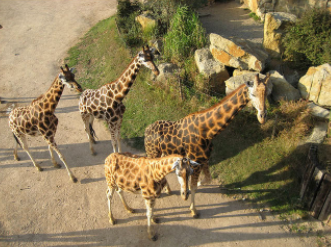

In [27]:
from IPython.display import Image,display_png
display_png(Image('png/example.png'))

ちゃんとキャプションついてる。

自分の画像でもやってみる

In [30]:
!python sample.py --image='png/test.jpg'

<start> a dog is laying on a couch with a dog . <end>


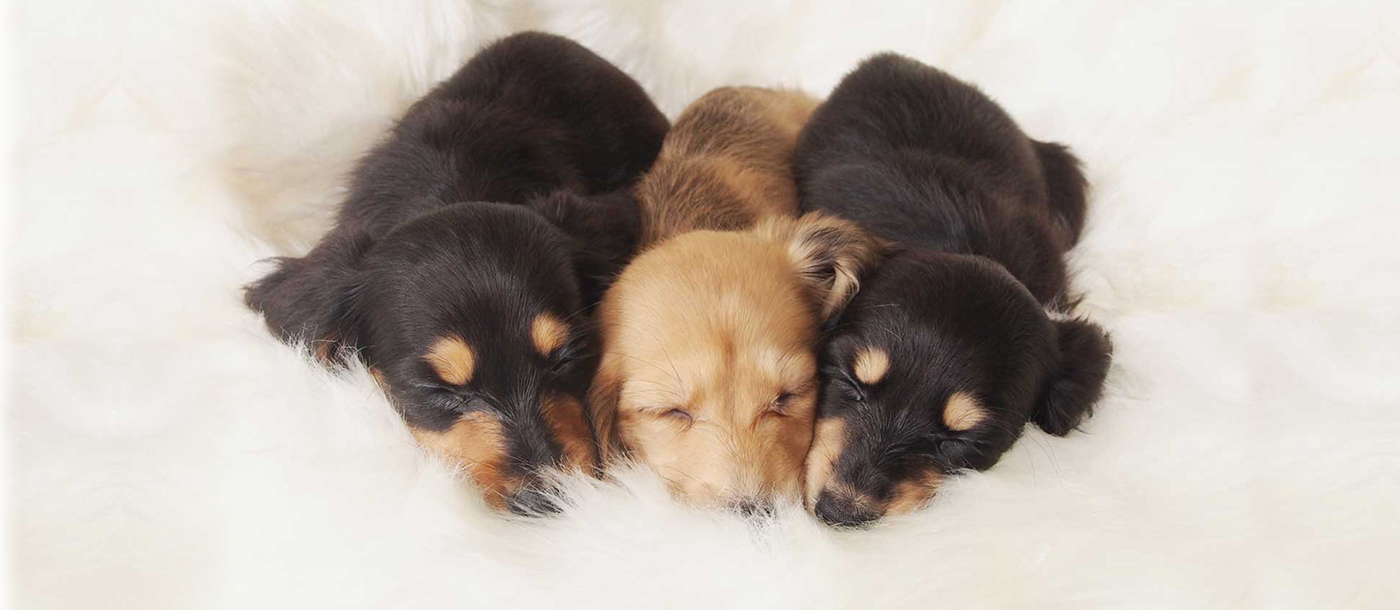

In [32]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('png/test.jpg'))

 a dog is laying on a couch with a dog
 
 犬が犬と一緒にソファに寝そべっている

割と出来ている。眠っているかどうかは判定難しそう。


# 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

## 変換方法その1

* pytorch2kerasを使用する

[https://github.com/nerox8664/pytorch2keras](https://github.com/nerox8664/pytorch2keras)

1. keras.jsonのimage_data_formatを"channels_first"に書き換え。
2. kerasモデルに変換するコンバーターを作成。
3. pytorchモデルを作成。
4. ダミー変数を使用してモデルをトレース。
重みも一緒に

## その2
* MMdnnを使用する

[https://github.com/microsoft/MMdnn](https://github.com/microsoft/MMdnn)

インストールして変換モジュール回したら変えてくれるっぽい。
h5ファイルなど、ファイルに保存したモデルがあれば、それを指定して出力先の形式を選べばいい。ただしshapeをしっかり指定しないとエラーになる？


* 重み変換にはONNX？DLPack?

どちらもフレームワーク間テンソル共有が可能。
pytorch⇔ONNX⇔kerasが出来る。


# 【問題4】（アドバンス課題）コードリーディングと書き換え
モデル部分はmodel.pyに書かれていますが、Kerasではこのモデルがどのように記述できるかを考え、コーディングしてください。その際機械翻訳のサンプルコードが参考になります。



# 【問題5】（アドバンス課題）発展的調査
__《他の言語の翻訳を行う場合は？》__


問題1の実装を使い日本語と英語の翻訳を行いたい場合はどのような手順を踏むか考えてみましょう。


__《機械翻訳の発展的手法にはどのようなものがある？》__


機械翻訳のための発展的手法にはどういったものがあるか調査してみましょう。


__《文章から画像生成するには？》__


イメージキャプショニングとは逆に文章から画像を生成する手法もあります。どういったものがあるか調査してみましょう。